#Khai phá dữ liệu


##Import thư viện và tải dữ liệu tù kaggle

---



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 742k/742k [00:00<00:00, 1.61MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sulianova/cardiovascular-disease-dataset/versions/1


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, min, max, isnan, sum, countDistinct
from pyspark.sql.functions import floor, col,expr

##in 5 dòng đầu

In [3]:
spark = SparkSession.builder.appName("CardioAnalysis").getOrCreate()
csv_path = path + "/cardio_train.csv"
df = spark.read.csv(csv_path, header=True, sep=';', inferSchema=True)
df.show(5)

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



In [4]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_index = df.withColumn("row_id", monotonically_increasing_id())
df_last_5 = df_with_index.orderBy("row_id", ascending=False).limit(5)
df_last_5.show()

+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------+
|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|row_id|
+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------+
|99999|20540|     1|   170|  72.0|  120|   80|          2|   1|    0|   0|     1|     0| 69999|
|99998|22431|     1|   163|  72.0|  135|   80|          1|   2|    0|   0|     0|     1| 69998|
|99996|19066|     2|   183| 105.0|  180|   90|          3|   1|    0|   1|     0|     1| 69997|
|99995|22601|     1|   158| 126.0|  140|   90|          2|   2|    0|   0|     1|     1| 69996|
|99993|19240|     2|   168|  76.0|  120|   80|          1|   1|    1|   0|     1|     0| 69995|
+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------+



##Thông tin các cột trong bộ dữ liệu

In [5]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



|  Cột       |  Ý nghĩa    |  Ghi chú thêm                                     |
| ------------- | --------------------- | --------------------------------------------------- |
| `id`          | Mã số bệnh nhân       | Không có ý nghĩa trong mô hình, nên loại bỏ         |
| `age`         | Tuổi (tính theo ngày) | Nhóm sẽ chia 365 để tính tuổi theo năm                 |
| `gender`      | Giới tính             | 1: Nữ, 2: Nam                                       |
| `height`      | Chiều cao (cm)        | Có thể dùng để tính BMI                             |
| `weight`      | Cân nặng (kg)         | Kết hợp `height` để tính BMI                        |
| `ap_hi`       | Huyết áp tâm thu      | Giá trị cao có thể là dấu hiệu bệnh tim             |
| `ap_lo`       | Huyết áp tâm trương   |  kiểm tra outlier vì có nhiều giá trị bất thường |
| `cholesterol` | Mức cholesterol       | 1: Bình thường, 2: Cao, 3: Rất cao                  |
| `gluc`        | Mức đường huyết       | 1: Bình thường, 2: Cao, 3: Rất cao                  |
| `smoke`       | Hút thuốc             | 1: Có hút, 0: Không                                 |
| `alco`        | Uống rượu bia         | 1: Có uống, 0: Không                                |
| `active`      | Hoạt động thể chất    | 1: Có tập luyện, 0: Không tập                       |
| `cardio`      | Kết quả bệnh tim      | 1: Có bệnh tim mạch, 0: Không có  |


##Số dòng số cột

In [6]:
print("Số dòng:", df.count())
print("Số cột:", len(df.columns))

Số dòng: 70000
Số cột: 13


##Tìm cột bị trùng

In [7]:
duplicate_count = df.groupBy(df.columns).count().filter("count > 1").count()
duplicate_count

0

In [8]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+
|summary|                id|               age|             gender|            height|            weight|            ap_hi|             ap_lo|       cholesterol|              gluc|              smoke|                alco|            active|            cardio|
+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+
|  count|             70000|             70000|              70000|             70000|             70000|            70000|             70000|             70000|             70000|              70000|               70000

| Cột                       | Ý nghĩa                                                     |
| ------------------------- | ---------------------------------------------------------------------------- |
| `age`                     | Trung bình \~19469 ngày ≈ **53 tuổi**. Min = 10k ngày (\~29 tuổi) →  Hợp lý |
| `height`                  | Min = **55cm**, Max = **250cm** →  Có outlier                              |
| `weight`                  | Min = **10kg**, Max = **200kg** →  Cần xử lý dữ liệu bất thường            |
| `ap_hi`, `ap_lo`          | Min = **-150**, Max = **16020** →  Có giá trị sai → cần lọc                 |
| `cholesterol`, `gluc`     | Giá trị từ 1 đến 3 (bình thường → cao → rất cao)                             |
| `smoke`, `alco`, `active` | Nhị phân 0/1 → đã sẵn sàng dùng cho mô hình                                  |
| `cardio`                  | Nhãn (label) 0 hoặc 1 → phân bố đều (mean \~0.5)                            |


Nhằm đảm bảo chất lượng dữ liệu đầu vào cho mô hình học máy, nhóm đã thực hiện một số bước tiền xử lý để loại bỏ các giá trị bất hợp lý. Cụ thể:

Các mẫu có height < 100 hoặc height > 220 được loại bỏ vì đây là các giá trị không hợp lý đối với chiều cao con người, có thể do lỗi nhập liệu hoặc sai số đo lường. Nếu giữ lại, các giá trị này có thể gây nhiễu cho mô hình.

Tương tự, các giá trị weight < 30 hoặc weight > 180 cũng bị loại vì rơi vào khoảng rất hiếm gặp ở người lớn khỏe mạnh. Dữ liệu bất thường này nếu không được xử lý sẽ ảnh hưởng tiêu cực đến độ chính xác của mô hình dự đoán.

Các dòng có ap_hi <= 0 hoặc ap_hi > 250 được lọc ra khỏi tập dữ liệu. Trong đó, ví dụ như ap_hi = 16020 là một lỗi nhập liệu rõ ràng. Về bản chất, huyết áp tâm thu không thể âm hoặc quá cao vượt xa giới hạn sinh lý.

Cuối cùng, những mẫu có ap_lo <= 0 hoặc ap_lo > 200 cũng bị loại bỏ vì huyết áp tâm trương không thể mang giá trị âm và hiếm khi vượt quá 200. Giữ lại các giá trị này sẽ gây sai lệch nghiêm trọng cho việc phân tích và huấn luyện mô hình

#Tiền xử lý dữ liệu

In [9]:
df = df.filter((col("height").between(100, 220)) &
               (col("weight").between(30, 180)) &
               (col("ap_hi") > 0) & (col("ap_hi") < 250) &
               (col("ap_lo") > 0) & (col("ap_lo") < 200))

In [10]:
df = df.withColumn("age_years", floor(col("age") / 365)).drop("age")
df.show(10)

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+
| id|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+
|  0|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|       50|
|  1|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|       55|
|  2|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|       51|
|  3|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|       48|
|  4|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|       47|
|  8|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|       60|
|  9|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|       60|
| 12|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|       61|

In [11]:
df_pd = df.select(
    "age_years", "height", "weight", "ap_hi", "ap_lo",
    "cholesterol", "gluc", "smoke", "alco", "active", "cardio"
).toPandas()

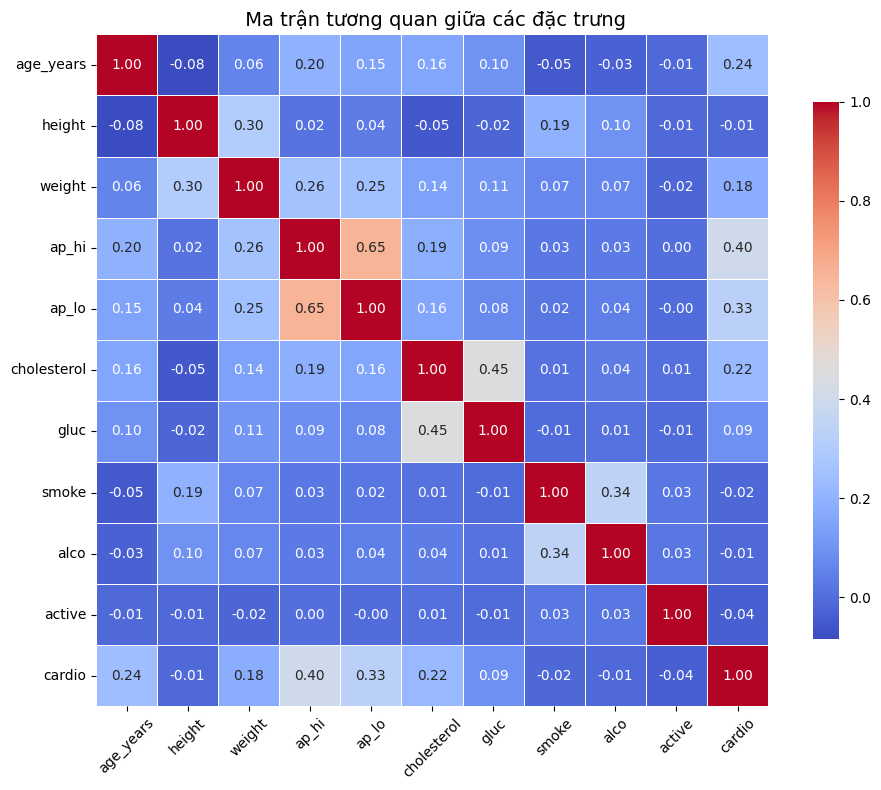

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

corr_matrix = df_pd.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title(" Ma trận tương quan giữa các đặc trưng", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


| Biến (feature)                    | Tương quan với `cardio` | Ý nghĩa thực tiễn                  |
| --------------------------------- | ----------------------- | ---------------------------------- |
| `age`                             | **+0.24**              | Tuổi cao → tăng nguy cơ bệnh tim   |
| `ap_hi` (huyết áp tâm thu)        | **+0.40**            | Rất mạnh → nên giữ                 |
| `ap_lo` (huyết áp tâm trương)     | **+0.33**               | Cũng có ảnh hưởng                  |
| `cholesterol`                     | **+0.22**               | Cholesterol cao liên quan bệnh tim |
| `weight`                          | **+0.18**               | Có ảnh hưởng nhẹ                   |
| `height`                          | **-0.01**               | Không ảnh hưởng  |
| `gluc`, `smoke`, `alco`, `active` | Gần 0                 | Không ảnh hưởng nhiều              |


 Phân tích cho thấy các biến có ảnh hưởng mạnh nhất đến khả năng mắc bệnh tim mạch (cardio) bao gồm:

`age `(tuổi)

`cholesterol` (mức cholesterol)

`gluc` (mức glucose)

`ap_hi` (huyết áp tâm thu)

`ap_lo`(huyết áp tâm trương)

Bên cạnh đó, nhóm nhận thấy rằng chiều cao có thể đóng vai trò nhất định trong việc dự đoán nguy cơ bệnh tim. Tuy nhiên, để phản ánh đầy đủ và chính xác hơn tình trạng thể chất của bệnh nhân, nhóm đã lựa chọn kết hợp chiều cao và cân nặng thành chỉ số BMI (Body Mass Index) – một thước đo chuẩn quốc tế giúp đánh giá mức độ thừa cân, béo phì và từ đó liên hệ đến nguy cơ mắc bệnh tim mạch.Và từ đó tính chiều cao cân nặng thành `bmi`



In [13]:
df_cleaned = df_pd.copy()
df_cleaned["bmi"] = df_cleaned["weight"] / ((df_cleaned["height"] / 100) ** 2)
df_cleaned.head()

,age_years,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [14]:
df_cleaned = df_pd.drop(columns=[ "gluc","smoke", "alco", "active"])
df_cleaned.head()

,age_years,height,weight,ap_hi,ap_lo,cholesterol,cardio
0,50,168,62.0,110,80,1,0
1,55,156,85.0,140,90,3,1
2,51,165,64.0,130,70,3,1
3,48,169,82.0,150,100,1,1
4,47,156,56.0,100,60,1,0


In [15]:
df_cleaned["bmi"] = df_cleaned["weight"] / ((df_cleaned["height"] / 100) ** 2)
df_cleaned.head()

,age_years,height,weight,ap_hi,ap_lo,cholesterol,cardio,bmi
0,50,168,62.0,110,80,1,0,21.967120
1,55,156,85.0,140,90,3,1,34.927679
2,51,165,64.0,130,70,3,1,23.507805
3,48,169,82.0,150,100,1,1,28.710479
4,47,156,56.0,100,60,1,0,23.011177


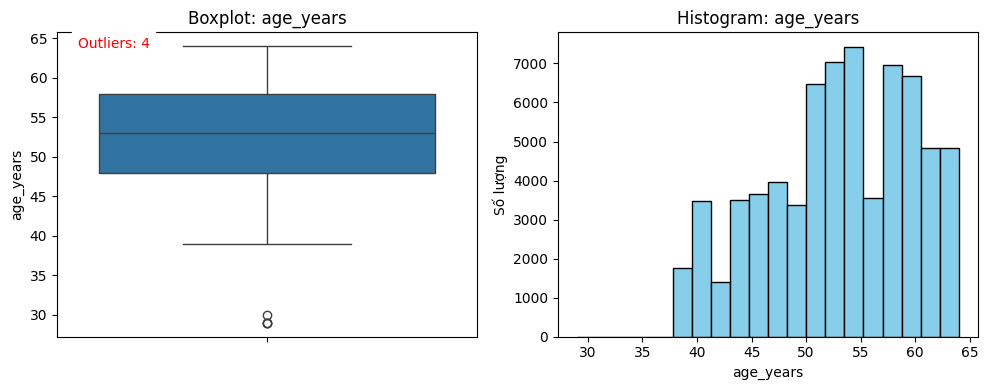

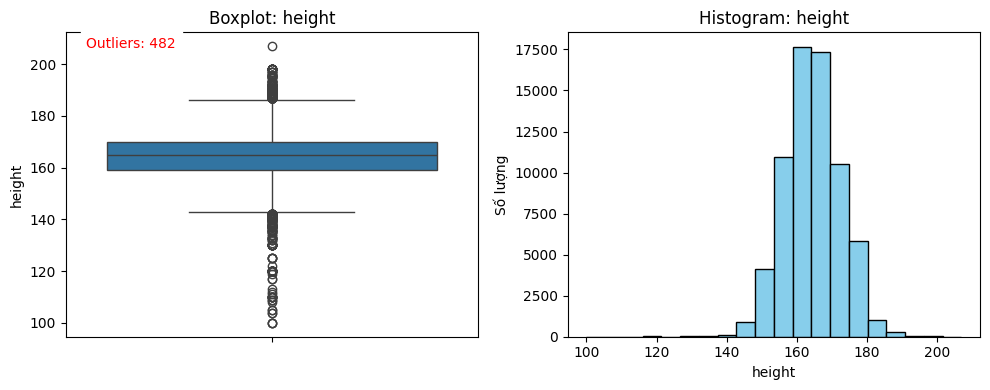

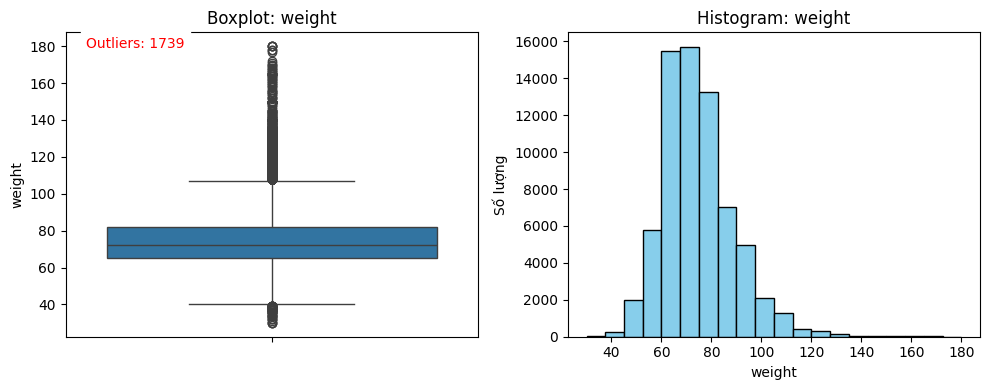

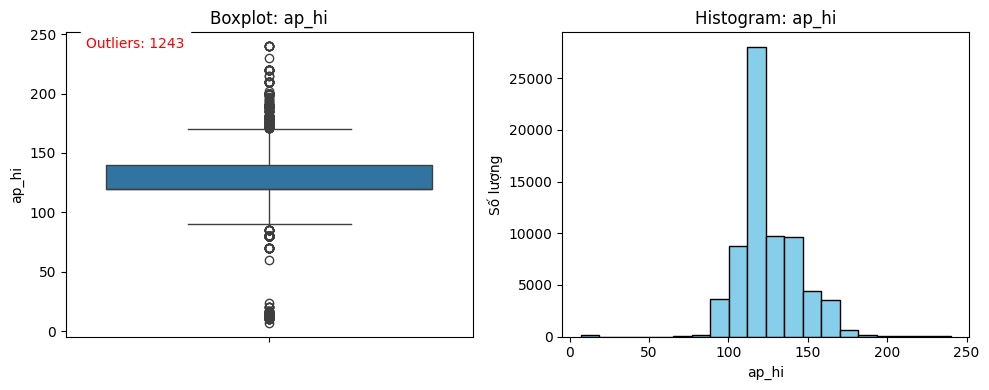

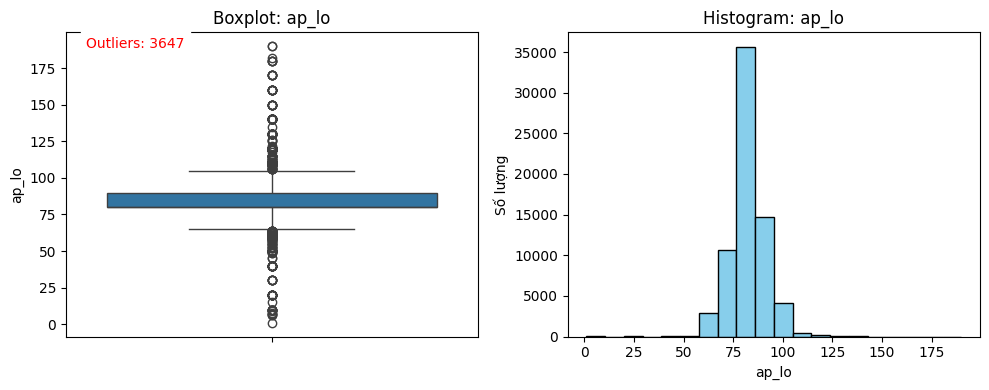

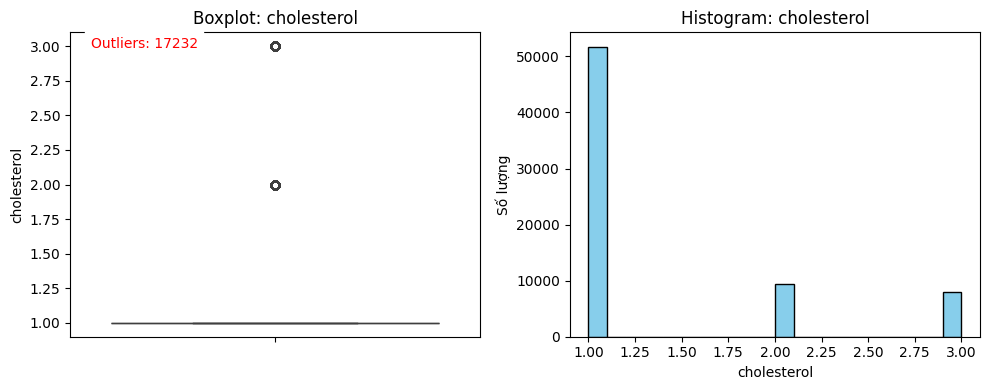

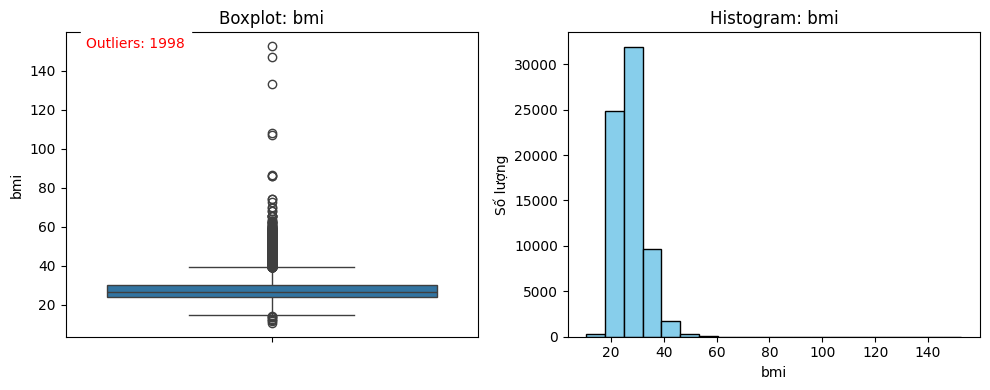

In [16]:
for col in df_cleaned.columns:
    if col != "cardio":
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Tính IQR để phát hiện outlier
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)][col]
        num_outliers = outliers.count()

        # Vẽ boxplot
        sns.boxplot(y=df_cleaned[col], ax=axs[0])
        axs[0].set_title(f'Boxplot: {col}')
        axs[0].set_ylabel(col)

        # Thêm chú thích số lượng outlier
        axs[0].annotate(f'Outliers: {num_outliers}',
                        xy=(0.05, 0.95), xycoords='axes fraction',
                        fontsize=10, color='red', backgroundcolor='white')

        # Vẽ histogram
        axs[1].hist(df_cleaned[col].dropna(), bins=20, edgecolor='black', color='skyblue')
        axs[1].set_title(f'Histogram: {col}')
        axs[1].set_xlabel(col)
        axs[1].set_ylabel("Số lượng")

        plt.tight_layout()
        plt.show()

Sau khi phân tích dữ liệu, nhóm phát hiện sự xuất hiện của nhiều giá trị bất thường (outliers) ở các cột sau:

age_years (Tuổi)

Số lượng outliers: 4

Các giá trị bất thường thuộc nhóm người quá trẻ so với phần lớn dữ liệu (ví dụ: dưới 40 tuổi).

Vì dữ liệu khá ổn định và chỉ lệch phải nhẹ, không cần xử lý.

height (Chiều cao)

Số lượng outliers: 482

Một số giá trị thấp dưới 140 cm hoặc cao trên 190 cm có thể là do sai sót nhập liệu hoặc thể trạng đặc biệt.

Nhóm quyết định giữ lại các giá trị này để tránh loại bỏ những trường hợp hợp lý hiếm gặp.

weight (Cân nặng)

Số lượng outliers: 1,739

Xuất hiện rải rác ở cả hai đầu: nhẹ cân (< 40 kg) và béo phì (> 120 kg). Phân phối lệch phải, phản ánh rõ nhóm người thừa cân.

Các giá trị này được giữ lại để phân tích mối liên hệ giữa thừa cân và bệnh tim mạch.

ap_hi (Huyết áp tâm thu)

Số lượng outliers: 1,243

Ghi nhận các giá trị bất thường rất thấp (~10–20) hoặc quá cao (> 180), trong đó một số trường hợp rõ ràng là lỗi nhập liệu.

Nhóm sẽ thay thế các giá trị bất hợp lý bằng NaN và áp dụng mô hình học máy để dự đoán, hiệu chỉnh giá trị phù hợp.

ap_lo (Huyết áp tâm trương)

Số lượng outliers: 3,647

Có nhiều giá trị thấp bất thường (< 40) hoặc cao vượt mức bình thường (> 110), ảnh hưởng tới độ tin cậy của mô hình.

Cần xử lý tương tự như ap_hi bằng cách gán NaN và hiệu chỉnh sau.

cholesterol (Cholesterol)

Số lượng outliers: 17,232

Dù đây là biến rời rạc, các mức cao (2 hoặc 3) chiếm tỷ lệ nhỏ nên được coi là bất thường về tần suất.

Tuy nhiên, nhóm vẫn giữ lại vì đây là đặc điểm lâm sàng quan trọng, có thể liên quan chặt chẽ đến bệnh tim mạch.

BMI (Chỉ số khối cơ thể)

Số lượng outliers: 1,998

Các giá trị cực cao > 60 hoặc cực thấp < 15 có thể bắt nguồn từ lỗi tính toán hoặc tình trạng sức khỏe đặc biệt.

Nhiều khả năng các giá trị này xuất phát từ dữ liệu chiều cao/cân nặng, do đó cần kiểm tra kết hợp trước khi quyết định xử lý.


In [17]:
spark = SparkSession.builder.appName("OutlierHandling").getOrCreate()
df_spark = spark.createDataFrame(df_cleaned)

In [18]:
from pyspark.sql.functions import col,expr
df_filtered = df_spark.filter(
    (col("bmi").between(13, 60)) &
    (col("age_years").between(18, 90)))
# Gán giá trị bất thường của ap_hi thành null
df_filtered = df_filtered.withColumn(
    "ap_hi",
    expr("CASE WHEN ap_hi < 80 OR ap_hi > 200 THEN NULL ELSE ap_hi END")
)
print("Số dòng sau khi lọc:", df_filtered.count())
print("Số dòng cần dự đoán lại ap_hi:", df_filtered.filter(col("ap_hi").isNull()).count())

Số dòng sau khi lọc: 68908
Số dòng cần dự đoán lại ap_hi: 243


Với cột `ap_hi`, nhóm quyết định thay thế outlier bằng NaN và dùng mô hình dự đoán để khôi phục các giá trị hợp lý vì:
- Dễ nhận diện lỗi nhập liệu nghiêm trọng (ví dụ < 20 hoặc > 240).
- Có mối quan hệ mạnh với các biến như `age_years`, `bmi`, `ap_lo`...
- Ảnh hưởng trực tiếp đến phân tích bệnh lý tim mạch.


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Bước 1: Lọc dữ liệu có ap_hi bị thiếu
df_predict = df_filtered.toPandas()
# Bước 2: Chọn các biến dự đoán
feature_cols = ['age_years', 'height', 'weight', 'ap_lo', 'cholesterol', 'bmi']
df_model = df_predict[feature_cols + ['ap_hi']].copy()

# Bước 3: Tách dữ liệu train/test
train_data = df_model[df_model['ap_hi'].notna()]
test_data = df_model[df_model['ap_hi'].isna()]

x_train = train_data[feature_cols]
y_train = train_data['ap_hi']
x_test = test_data[feature_cols]

# Xử lý thiếu trong x
imp = SimpleImputer(strategy="mean")
x_train_imp = imp.fit_transform(x_train)
x_test_imp = imp.transform(x_test)

# Bước 4: Huấn luyện mô hình
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train_imp, y_train)

# Dự đoán giá trị thiếu
predicted_ap_hi = model.predict(x_test_imp)

# Bước 5: Gán lại vào df_predict
df_predict.loc[df_predict['ap_hi'].isna(), 'ap_hi'] = predicted_ap_hi

# Kiểm tra lại
print("Số dòng còn thiếu ap_hi sau khi dự đoán:", df_predict['ap_hi'].isna().sum())

Số dòng còn thiếu ap_hi sau khi dự đoán: 0


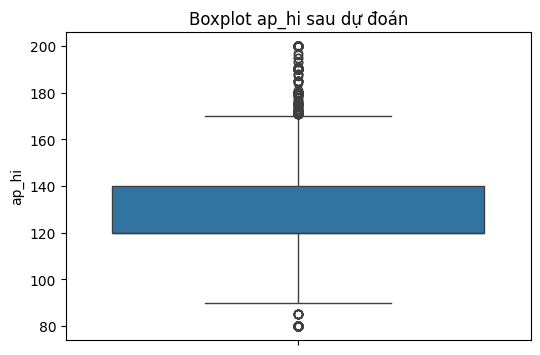

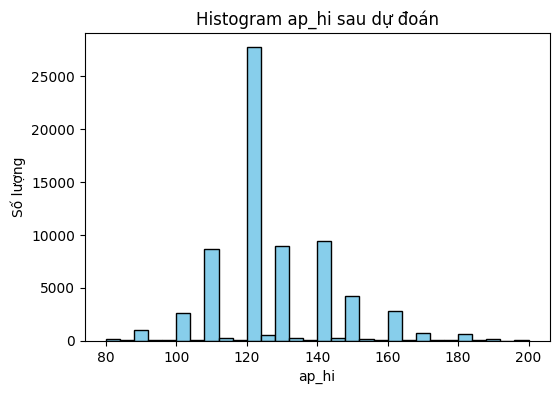

In [20]:
# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(y=df_predict['ap_hi'])
plt.title("Boxplot ap_hi sau dự đoán")
plt.show()

# Histogram
plt.figure(figsize=(6,4))
plt.hist(df_predict['ap_hi'], bins=30, edgecolor='black', color='skyblue')
plt.title("Histogram ap_hi sau dự đoán")
plt.xlabel("ap_hi")
plt.ylabel("Số lượng")
plt.show()


##Kiểm tra lại

In [21]:
df_predict.describe()

,age_years,height,weight,ap_hi,ap_lo,cholesterol,cardio,bmi
count,68908.000000,68908.000000,68908.000000,68908.000000,68908.000000,68908.000000,68908.000000,68908.000000
mean,52.826580,164.410460,74.087390,126.581195,81.349887,1.364486,0.494906,27.448379
std,6.768656,7.934723,14.192562,16.564942,9.801078,0.678771,0.499978,5.207011
min,29.000000,100.000000,30.000000,80.000000,1.000000,1.000000,0.000000,13.493001
25%,48.000000,159.000000,65.000000,120.000000,80.000000,1.000000,0.000000,23.875115
50%,53.000000,165.000000,72.000000,120.000000,80.000000,1.000000,0.000000,26.346494
75%,58.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,30.116213
max,64.000000,207.000000,180.000000,200.000000,190.000000,3.000000,1.000000,60.000000


Mặc dù một số giá trị như height = 207 cm, weight = 180 kg, hay BMI = 60 nằm ngoài phạm vi phổ biến, nhóm chủ động giữ lại các outlier này vì:

Chúng có thể là những trường hợp đặc biệt có thật, như béo phì hoặc thể trạng dị biệt – quan trọng với phân tích bệnh lý tim mạch.

ap_lo = 1 vốn chắc chắn là lỗi nhập liệu->nhóm sẽ tiến hành lọc dữ liệu lần nữa



###  Ngưỡng huyết áp tâm trương (`ap_lo`)  ảnh hưởng đến sức khỏe
Đây là trạng thái huyết áp tâm trương mà nhóm tìm được.

| **Trạng thái**       | **ap_lo cực trị**     | **Tác động**                                                                 |
|----------------------|------------------------|-------------------------------------------------------------------------------|
| Quá thấp   | < 40 mmHg              | Nguy cơ sốc tuần hoàn, suy đa cơ quan, **đe dọa tính mạng**                  |
| Quá cao              | > 120–130 mmHg         | Gây tổn thương tim, thận, mạch máu; **tăng nguy cơ đột quỵ, biến chứng nặng** |

->Ngưỡng an toàn sinh lý thực tế: khoảng 40 mmHg đến 120 mmHg

In [22]:
df_predict = df_predict[df_predict['ap_lo'].between(40, 120)]

In [23]:
df_predict.describe()

,age_years,height,weight,ap_hi,ap_lo,cholesterol,cardio,bmi
count,68769.000000,68769.000000,68769.000000,68769.000000,68769.000000,68769.000000,68769.000000,68769.000000
mean,52.824907,164.409850,74.075032,126.579181,81.291527,1.364118,0.494365,27.443978
std,6.769811,7.933894,14.181684,16.486010,9.380132,0.678439,0.499972,5.202859
min,29.000000,100.000000,30.000000,80.000000,40.000000,1.000000,0.000000,13.493001
25%,48.000000,159.000000,65.000000,120.000000,80.000000,1.000000,0.000000,23.875115
50%,53.000000,165.000000,72.000000,120.000000,80.000000,1.000000,0.000000,26.346494
75%,58.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,30.116213
max,64.000000,207.000000,180.000000,200.000000,120.000000,3.000000,1.000000,60.000000


Sau khi lọc ap_lo, dữ liệu sạch và đáng tin cậy hơn. BMI và weight cho thấy nhiều người thừa cân, nên nhóm quyết định giữ lại để phân tích nguy cơ bệnh tim. Tuổi tập trung ở nhóm trung niên – đúng đối tượng dễ mắc bệnh. Cardio gần cân bằng giữa 0 và 1, rất phù hợp để huấn luyện mô hình. Cholesterol tuy phần lớn ở mức bình thường nhưng vẫn có vài giá trị cao, cần giữ lại để phân tích thêm.



In [24]:
pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
import boto3

filename = "cardio_clean.csv"
df_predict.to_csv(filename, index=False)

aws_access_key = 'xxx'
aws_secret_key = 'xxx'
region = 'ap-southeast-1'
bucket_name = 'public-bucket-nhuttan-01'


s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key,
                  aws_secret_access_key=aws_secret_key,
                  region_name=region)

s3.upload_file(Filename=filename,
               Bucket=bucket_name,
               Key=f"data/processed/{filename}")

print(f" Đã upload {filename} lên bucket `{bucket_name}`")


 Đã upload cardio_clean.csv lên bucket `public-bucket-nhuttan-01`


## **Tài liệu tham khảo**
- https://viblo.asia/p/xu-ly-missing-data-trong-data-analysis-maGK7qaAlj2#_su-dung-mo-hinh-du-doan-cho-data-impution-13